In [1]:
from math import sqrt
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
class Scaler():
    def standardize(self, data: pd.DataFrame, exclude: List[str]=None):
        for label in data.columns:
            if label not in exclude:
                mean = data[label].mean()
                std = data[label].std()
                
                data[label] = (data[label] - mean) / std
                
    def min_max(self, data: pd.DataFrame, exclude: List[str]=None):
        for label in data.columns:
            if label not in exclude:
                min = data[label].min()
                max = data[label].max()

                data[label] = (data[label] - min) / (max - min)

In [47]:
class DataLoader():
    def __init__(self, data: pd.DataFrame, target_label, split=0.8):
        self.data_size = len(data)

        self.train_size = int(self.data_size * split)
        self.val_size = self.data_size - self.train_size

        train_data = data[:self.train_size]
        val_data = data[self.train_size:]

        self.input_train = np.array(train_data.drop(target_label, axis=1))
        self.target_train = np.array(train_data[target_label])
        
        self.input_val = np.array(val_data.drop(target_label, axis=1))
        self.target_val = np.array(val_data[target_label])

        self.features = len(data.columns) - 1

    def get_training(self):
        return self.input_train, self.target_train
    
    def get_validation(self):
        return self.input_val, self.target_val

In [44]:
data = pd.read_csv("Dummy-Data-HSS.csv")
data.drop(columns=["Influencer"], inplace=True)
data.fillna(0, inplace=True)

data.head(10)

,TV,Radio,Social Media,Sales
0,16.0,6.566231,2.907983,54.732757
1,13.0,9.237765,2.409567,46.677897
2,41.0,15.886446,2.913410,150.177829
3,83.0,30.020028,6.922304,298.246340
4,15.0,8.437408,1.405998,56.594181
5,29.0,9.614382,1.027163,105.889148
6,55.0,24.893811,4.273602,198.679825
7,31.0,17.355042,2.289855,108.733932
8,76.0,24.648898,7.130116,270.189400
9,13.0,0.431128,2.229423,48.280582


In [50]:
scaler = Scaler()
scaler.standardize(data, exclude=["Sales"])

data_loader = DataLoader(data, "Sales")

data.head(10)

,TV,Radio,Social Media,Sales
0,-1.447401,-1.195158,-0.185872,54.732757
1,-1.561825,-0.919390,-0.410942,46.677897
2,-0.493874,-0.233083,-0.183421,150.177829
3,1.108052,1.225849,1.626880,298.246340
4,-1.485542,-1.002007,-0.864125,56.594181
5,-0.951567,-0.880514,-1.035196,105.889148
6,0.040102,0.696698,0.430803,198.679825
7,-0.875285,-0.081488,-0.465001,108.733932
8,0.841065,0.671417,1.720722,270.189400
9,-1.561825,-1.828452,-0.492290,48.280582


In [68]:
class LinearRegression():
    def __init__(self):
        self.w = None
        self.b = 0

        self._model = lambda x: self.w.dot(x) + self.b

    def train(self, data_loader: DataLoader, epoch = 10, learning_rate = 0.01, lasso = 0, ridge = 0):
        input_train, target_train = data_loader.get_training() 
        input_val, target_val = data_loader.get_validation()

        self.w = np.zeros(data_loader.features)

        train_size = data_loader.train_size
        val_size = data_loader.val_size

        train_rmsd = []
        val_rmsd = []

        sign = np.vectorize(lambda x : 1 if x >= 0 else -1)

        for _ in range(epoch):
            train_cost = 0
            val_cost = 0

            for idx in range(train_size):
                input, target = input_train[idx], target_train[idx]

                prediction = self._model(input)

                error = prediction - target

                train_loss = np.power(error, 2) / 2

                train_cost += train_loss

                l1_update = lasso * sign(self.w)

                l2_update = (2 * ridge) * self.w

                regularization_term = l1_update + l2_update

                update_term = (error * input) + regularization_term

                self.w -= learning_rate * update_term

                self.b -= learning_rate * error


            for idx in range(val_size):
                input, target = input_val[idx], target_val[idx]

                prediction = self._model(input)

                error = prediction - target

                val_loss = np.power(error, 2) / 2

                val_cost += val_loss


            train_rmsd.append(sqrt(train_cost / train_size))
            val_rmsd.append(sqrt(val_cost / val_size))

        return train_rmsd, val_rmsd

In [65]:
linear = LinearRegression()

train_rmsd, val_rmsd = linear.train(data_loader, 15, 0.0001)

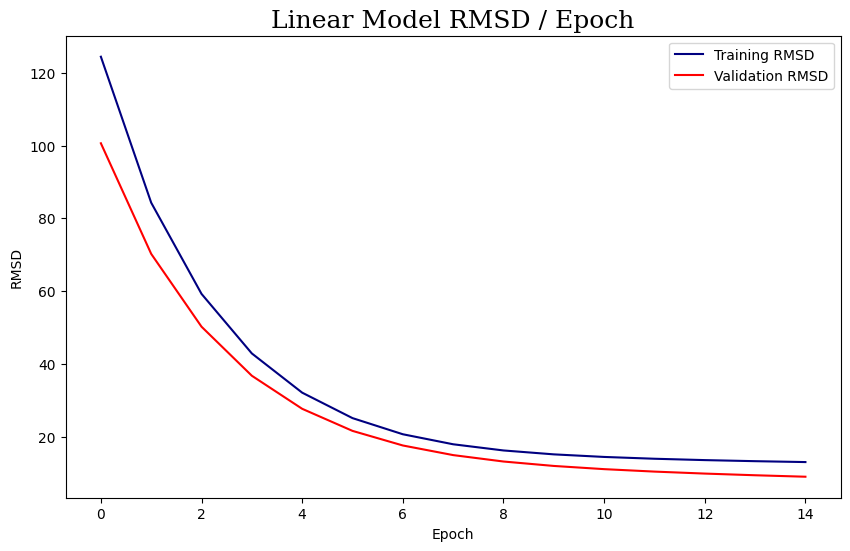

In [72]:
plt.figure(figsize=(10, 6))

plt.plot(train_rmsd, color="navy", label="Training RMSD")
plt.plot(val_rmsd, color="red", label="Validation RMSD")

plt.xlabel("Epoch")
plt.ylabel("RMSD")

plt.title("Linear Model RMSD / Epoch", size=18, family="serif")
plt.legend(loc="upper right")

plt.show()